### This is my CNN classifcation model for Fundus to determine diabetes in patients

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<ipython-input-2-4a079da681bb>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='DR_grade', palette='viridis')


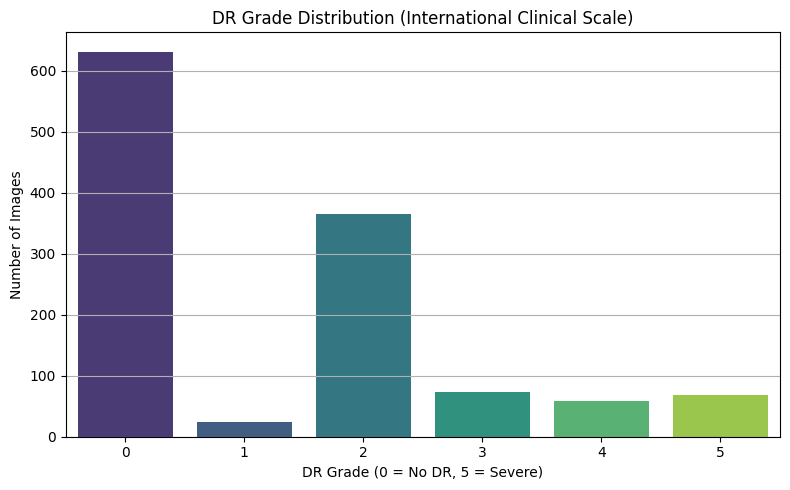

,filename,left_versus_right_eye(left_0_right_1),DR_grade,DR_grade(American_Academy_of_Ophthalmology),DR_grade(Scottish_DR_grading_protocol),image_path
0,0001.jpg,0,0,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...
1,0002.jpg,0,0,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...
2,0003.jpg,0,0,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...
3,0004.jpg,0,0,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...
4,0005.jpg,0,0,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Change the path to whatever the path you are using is:
csv_path = '/content/drive/MyDrive/MLMA Final Project/Diabetic Retinography CNN/1030The SUSTech-SYSU dataset for automated exudate detection and diabetic retinopathy grading/originalImages/drLabels.csv'

# Read CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Remove empty space from column names

# Rename and clean DR label column
df.rename(columns={
    'Fundus_images': 'filename',
    'DR_grade(International_Clinical_DR_Severity_Scale)': 'DR_grade'
}, inplace=True)
df['DR_grade'] = df['DR_grade'].astype(int)

# Adjust this to whatever path you are using for each independent image:
image_folder = '/content/drive/MyDrive/MLMA Final Project/Diabetic Retinography CNN/1030The SUSTech-SYSU dataset for automated exudate detection and diabetic retinopathy grading/originalImages'
df['image_path'] = df['filename'].apply(lambda name: os.path.join(image_folder, name))

# Plot DR grade distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='DR_grade', palette='viridis')
plt.title('DR Grade Distribution (International Clinical Scale)')
plt.xlabel('DR Grade (0 = No DR, 5 = Severe)')
plt.ylabel('Number of Images')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


df.head()


In [3]:
# Count total number of images/patients
total_images = len(df)

# Count how many are labeled as DR grade 0 (no DR)
num_no_dr = (df['DR_grade'] == 0).sum()

print(f"Total number of images (patients): {total_images}")
print(f"Number with DR grade 0 (no DR): {num_no_dr}")
print(f"Number with DR grade 1-5 (no DR): {total_images-num_no_dr}")


Total number of images (patients): 1219
Number with DR grade 0 (no DR): 631
Number with DR grade 1-5 (no DR): 588


Creating a binary classification with 0 and 1 versus 3-5

In [4]:
# Binary label: 0 if grade is 0 or 1 (no/mild DR), 1 if grade is 2–5 (moderate or worse)
df['DR_binary'] = df['DR_grade'].apply(lambda x: 0 if x < 1 else 1)

# Quick check
print(df[['DR_grade', 'DR_binary']].value_counts().sort_index())

# Drop unwanted columns
df = df.drop(columns=[
    'DR_grade(American_Academy_of_Ophthalmology)',
    'DR_grade(Scottish_DR_grading_protocol)'
], errors='ignore')  # errors='ignore' in case already cleaned

df.head()

DR_grade  DR_binary
0         0            631
1         1             24
2         1            365
3         1             73
4         1             58
5         1             68
Name: count, dtype: int64


,filename,left_versus_right_eye(left_0_right_1),DR_grade,image_path,DR_binary
0,0001.jpg,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...,0
1,0002.jpg,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...,0
2,0003.jpg,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...,0
3,0004.jpg,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...,0
4,0005.jpg,0,0,/content/drive/MyDrive/MLMA Final Project/Diab...,0


In [5]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Parameters
IMG_SIZE = 224
NUM_CLASSES = 6

# Filter out missing images
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Convert labels to categorical
df['DR_grade_cat'] = to_categorical(df['DR_grade'], num_classes=NUM_CLASSES).tolist()

# # Load images and labels
# X = []
# y = []

# for i, row in tqdm(df.iterrows(), total=len(df)):
#      img = load_img(row['image_path'], target_size=(IMG_SIZE, IMG_SIZE))
#      img = img_to_array(img) / 255.0
#      X.append(img)
#      y.append(row['DR_grade_cat'])

# X = np.array(X)
# y = np.array(y)


In [6]:
# Separate by class
df_pos = df[df['DR_binary'] == 1]  # DR grades 2–5
df_neg = df[df['DR_binary'] == 0]  # DR grades 0–1

# Balance them
n_samples = min(len(df_pos), len(df_neg))  # Make both classes equal

df_balanced = pd.concat([
    df_pos.sample(n_samples, random_state=42),
    df_neg.sample(n_samples, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


In [7]:
print(df_balanced['DR_binary'].value_counts())

DR_binary
1    588
0    588
Name: count, dtype: int64


Pre-process the image:

Apply clahe to enrich the feature channels and improve the model and standardize the size of each image.

In [8]:
import cv2
import numpy as np

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return img_clahe

In [9]:
import cv2

# Create lists containing resized images (X) and corresponding labels (y)

X = []
y = []

for i, row in tqdm(df_balanced.iterrows(), total=len(df_balanced)):
    if not os.path.exists(row['image_path']):
        continue

    img = cv2.imread(row['image_path'])
    img = cv2.resize(img, (224, 224))
    img = apply_clahe(img) / 255.0
    X.append(img)
    y.append(row['DR_binary'])

X = np.array(X)
y = np.array(y)


100%|██████████| 1176/1176 [12:11<00:00,  1.61it/s]


In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Build our model:

In [24]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers for faster training (unfreeze later if needed)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5582 - loss: 0.7127 - val_accuracy: 0.9468 - val_loss: 0.3232
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8585 - loss: 0.3668 - val_accuracy: 0.9574 - val_loss: 0.2124
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9039 - loss: 0.2632 - val_accuracy: 0.9628 - val_loss: 0.1778
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9301 - loss: 0.2105 - val_accuracy: 0.9628 - val_loss: 0.1593
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9371 - loss: 0.2045 - val_accuracy: 0.9628 - val_loss: 0.1490
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9510 - loss: 0.1768 - val_accuracy: 0.9521 - val_loss: 0.1426
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9376 - loss: 0.1867 - val_accuracy: 0.9628 - val_loss: 0.1377
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9386 - loss: 0.1719 - val_accuracy: 0.9574 - val_loss:

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       118
           1       0.96      0.87      0.92       118

    accuracy                           0.92       236
   macro avg       0.92      0.92      0.92       236
weighted avg       0.92      0.92      0.92       236



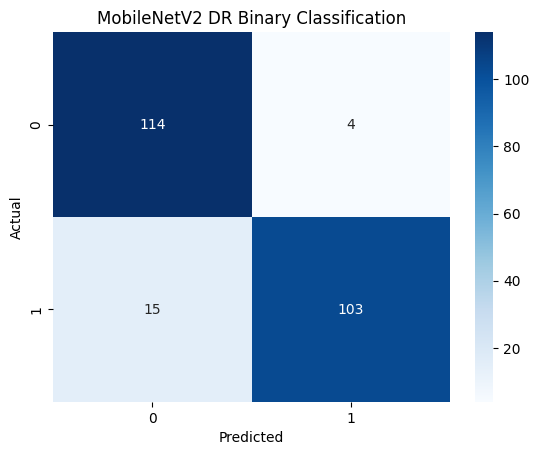

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_test_pred = model.predict(X_test).flatten()
y_test_pred_label = (y_test_pred > 0.5).astype(int)

print(classification_report(y_test, y_test_pred_label))

cm = confusion_matrix(y_test, y_test_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("MobileNetV2 DR Binary Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [27]:
model.save('/content/drive/MyDrive/DR_MobileNet_binary_0vs1to5_10epoch.h5')

In [17]:
from tensorflow.keras.models import load_model

cnn_model = load_model('/content/drive/MyDrive/MLMA Final Project/Diabetic Retinography CNN/DR_MobileNet_binary_10epoch.h5')

In [18]:
# Avoid log(0) or division by zero
epsilon = 1e-7
logits_cnn = np.log(y_test_pred / (1 - y_test_pred + epsilon) + epsilon)

import numpy as np

# Save
np.save('/content/drive/MyDrive/logits_cnn.npy', logits_cnn)
np.save('/content/drive/MyDrive/y_val.npy', y_val)

# Later load
# logits_cnn = np.load('/content/drive/MyDrive/logits_cnn.npy')
# y_val = np.load('/content/drive/MyDrive/y_val.npy')

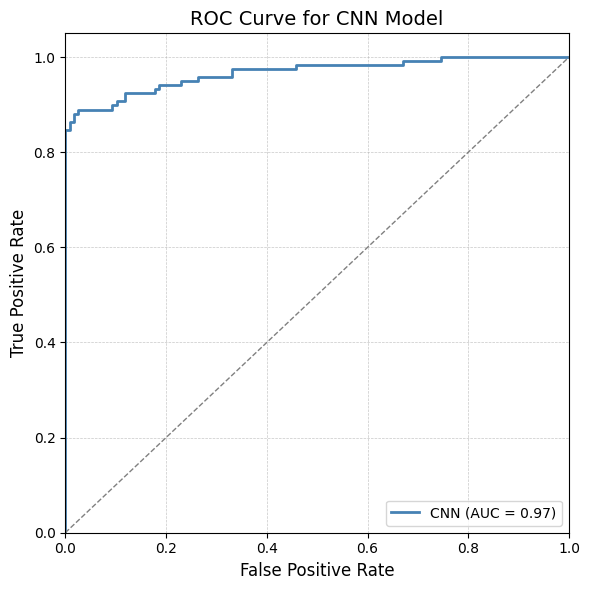

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming you already have logits_cnn and y_val loaded
# Example:
# logits_cnn = model.predict(X_val).ravel()
# y_val = actual labels

# Load your model (skip if logits_cnn is already available)
# cnn_model = load_model('/content/drive/MyDrive/MLMA Final Project/Diabetic Retinography CNN/DR_MobileNet_binary_10epoch.h5')

# Calculate AUC
roc_auc = roc_auc_score(y_test, logits_cnn)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, logits_cnn)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='steelblue', lw=2, label='CNN (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for CNN Model', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/DR_MobileNet_binary_0vs1to5_10epoch.h5')

Fine tune by unfreezing the base layer

In [29]:
# Unfreeze the base model
model.layers[0].trainable = True

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9549 - loss: 0.1497 - val_accuracy: 0.9574 - val_loss: 0.1298
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9448 - loss: 0.1588 - val_accuracy: 0.9574 - val_loss: 0.1295
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9600 - loss: 0.1348 - val_accuracy: 0.9574 - val_loss: 0.1291
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9500 - loss: 0.1527 - val_accuracy: 0.9574 - val_loss: 0.1290
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9322 - loss: 0.1595 - val_accuracy: 0.9574 - val_loss: 0.1288


In [30]:
y_test_pred = model.predict(X_test).flatten()
y_test_pred_label = (y_test_pred > 0.5).astype(int)

print(classification_report(y_test, y_test_pred_label))

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       118
           1       0.98      0.87      0.92       118

    accuracy                           0.93       236
   macro avg       0.93      0.93      0.93       236
weighted avg       0.93      0.93      0.93       236



In [31]:
model.save('/content/drive/MyDrive/DR_MobileNet_binary_0vs1to5_finetuned.h5')

In [32]:
# Avoid log(0) or division by zero
epsilon = 1e-7
logits_cnn = np.log(y_test_pred / (1 - y_test_pred + epsilon) + epsilon)

import numpy as np

# Save
np.save('/content/drive/MyDrive/MLMA Final Project/Rough Project Outline/logits_cnn_ft.npy', logits_cnn)
np.save('/content/drive/MyDrive/MLMA Final Project/Rough Project Outline/y_test_ft.npy', y_val)

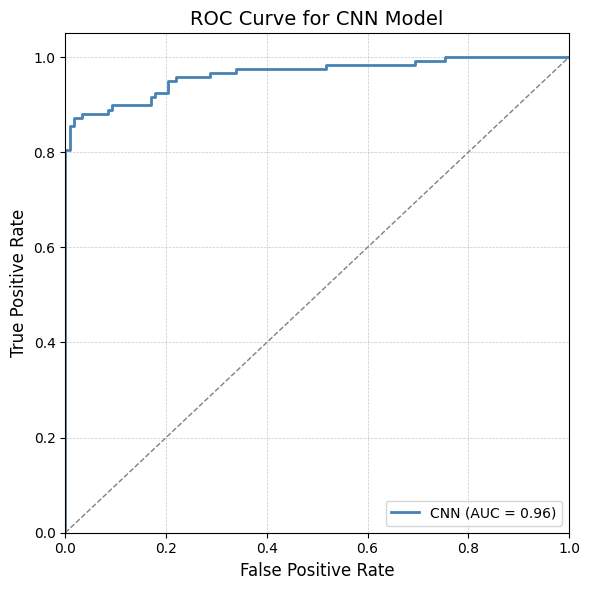

In [33]:
roc_auc = roc_auc_score(y_test, logits_cnn)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, logits_cnn)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='steelblue', lw=2, label='CNN (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for CNN Model', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()